# Preprocessing GrandPad Google Play Reviews

Import required libraries.

In [1]:
import pandas as pd
from langdetect import detect_langs
import re
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
from utils.review_utils import get_google_play_data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pathlib import Path
import os
import pyLDAvis
import pyLDAvis.lda_model
from utils.review_utils import find_reviews_by_keyword_list

## Scraping and Analyzing Data

First, scrape the reviews from the Google Play Store.

In [2]:
# Get reviews
APP_ID = 'net.grandpad.puma'
reviews = get_google_play_data(APP_ID)
df = pd.DataFrame(reviews)

# Print a few reviews (just the score and content)
print('Score  Content')
print('--------------')
for i in range(5):
    print(f"{df.iloc[i]['score']:<7}{df.iloc[i]['content']}")

Score  Content
--------------
5      Love the app for keeping my family in touch.
5      Grandpad is a great way to stay connected to those near and far.
5      My 94 year old aunt always tells me how much she loves her GrandPad! She's become very proficient at making phone calls, & sending voice & text messages. And she loves the photo display!
5      Enjoyed and used by the whole family
4      Great medium to remain in contact with our loved ones.


In [3]:
# Print number of rows in the data
rows0 = df.shape[0]
print(f'Initially there are {rows0:,} reviews')

Initially there are 1,823 reviews


The length of the reviews might give important insight into the quality of the review.

In [4]:
# Make column for word count (of the review content)
df['word_count'] = df['content'].str.split().apply(lambda s: 0 if s == None else len(s))

Plotting the distribution of the word counts of the reviews, we see that the vast majority of the reviews contain fewer than 10 words.

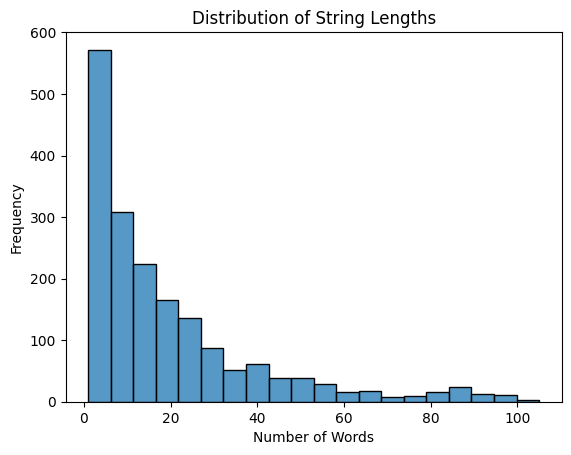

In [5]:
# Histogram of the word count of the reviews
sns.histplot(df['word_count'], bins=20)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of String Lengths')
plt.show()

## Preprocessing Step 1: Removing Short Reviews

We will remove short reviews, since they probably don't contain much useful information.

In [6]:
# Make column for word count (of the review content)
df['word_count'] = df['content'].str.split().apply(lambda s: 0 if s == None else len(s))

# Remove short reviews
REVIEW_WORD_COUNT_THRESHOLD = 10
df = df[df['word_count'] >= REVIEW_WORD_COUNT_THRESHOLD]

In [7]:
# Print number of rows in the data after filtering out short reviews
rows1 = df.shape[0]
print(f'After filtering out short reviews, we have {rows1:,} reviews (removed {rows0 - rows1:,} reviews)')

After filtering out short reviews, we have 1,063 reviews (removed 760 reviews)


## Preprocessing Step 4: Splitting Reviews By Rating

It is likely that reviews that rate the app highly will have positive things to say about the app, whereas reviews with lower ratings will contain complaints about the app.
Positive reviews can be used to detect requirements that are being satisfied and negative reviews can point to ignored requirements (or new, previously unspecified requirements).

Shown below, most of the reviews are 1 star, with 5 star reviews following close behind.
Reviews with 2, 3, and 4 stars are significantly smaller in number, but when combined together have almost the same amount as the 1 and 5 star reviews.

In [8]:
# Print the counts of each rating
print(df['score'].value_counts().sort_index())

score
1     46
2     17
3     36
4     80
5    884
Name: count, dtype: int64


In [9]:
# Split the reviews into negative (1 star), mixed (2, 3, and 4 stars), and
# positive (5 stars)
df_negative = df[df['score'] == 1].copy()
df_mixed = df[(df['score'] == 2) | (df['score'] == 3) | (df['score'] == 4)].copy()
df_positive = df[df['score'] == 5].copy()

Shown below, the 1 star reviews are mostly negative,

In [10]:
for i in range(5):
    print(f"{df_negative.iloc[i]['content']}\n")

Speakerphone no longer working I would give zero stars if possible

95% of the time, it seems, this is worthless. My aunt is in a nursing home -- that's why I bought a grandpad, but I usually cannot hear her. Yes, I have tried numerous times w the help center.

This app is not functioning as it should. I was on a regular phone call and the Grandpad rang through while I was on the phone call, interrupting my call. Additionally, I had my phone on no not disturb and the Grandpad app still somehow rang through. There are bugs that need to be worked out because this app is terrible.

I am so upset right now because I put in my email address and they say it's wrong what does this app want lies a am starting to believe that this app is a scam I am Uninstalling they won't let me do my email account because they say they don't have it developers please fix this issue I am feeling sad 😔 right now so disappointed 😥 this app looked like fun only problem is that they don't like my email account

Un

the 2, 3, and 4 star reviews are mixed,

In [11]:
for i in range(5):
    print(f"{df_mixed.iloc[i]['content']}\n")

Great medium to remain in contact with our loved ones.

Once you have figured out how to set it up it's an awesome device. It almost got thrown across the room while I was trying to get it up and running for my 86 yo mother who has dementia. Once it's set up though it's easy. I highly recommend to get this before the senior citizen is as advanced in dementia as my mom is. She is scared of it and even though I tell her to practice and reassure her she can't mess it up she still won't use it alone.

So far, this app is great. My grandma is having an easier time with this than other social apps

I have a few questions on posting things & submitted it. Waiting on a response.

The app is fantastic. It's a great way to keep in touch with loved ones. I love that I can post videos and pictures or do video calls with anyone in my family who has access to the app. Also I love some of the recent changes. Keep up the good work, Grandpad!



and the 5 star reviews are mostly positive.

In [12]:
for i in range(5):
    print(f"{df_positive.iloc[i]['content']}\n")

Grandpad is a great way to stay connected to those near and far.

My 94 year old aunt always tells me how much she loves her GrandPad! She's become very proficient at making phone calls, & sending voice & text messages. And she loves the photo display!

Easy to use! Large variety of music, easy to load photos!

This makes sharing photos and memories with my senior citizen father much easier. We are able to connect very easily and he can call me without memorizing a phone number. That adds to helping him feel more independent as he ages.

The screen and user interface are simple, and easy to use for mom. Just the right features to stay in touch and share photos/videos.



## Saving Preprocessed Data to Files

As the last step, we will save the dataframes to CSV files so that they can be used later.

In [13]:
NOTEBOOK_PATH = Path(os.path.abspath(''))
DATA_PATH = NOTEBOOK_PATH.parent / 'data'

# Ensure data directory exists
DATA_PATH.mkdir(exist_ok=True)

In [14]:
nltk.download('wordnet')

numbers_re = re.compile(r'\d+')
punctuation_re = re.compile(r'[^\w\s]')
extra_spaces_re = re.compile(r'\s+')

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Cleans `text` by:
      - setting it to lower case,
      - removing numbers,
      - removing punctuation,
      - removing extra spaces,
      - lemmatizing words, and
      - removing stopwords.
    """
    text = text.lower()
    text = numbers_re.sub(r'', text)
    text = punctuation_re.sub('', text)
    text = extra_spaces_re.sub(' ', text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stopwords.words('english')])
    return text

[nltk_data] Downloading package wordnet to /home/daniel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
def make_lda_model(df: pd.DataFrame):
    """
    Makes a LatentDirichletAllocation (LDA) model of the data in `df` DataFrame.
    `df` must have a `'cleaned_content'` column that contains the cleaned
    content of the reviews.

    Returns:

    `lda_model` - the generated LDA model.

    `vectorizer` - the vectorizer that was used on the reviews to convert the
    text data into numbers.

    `X` - the vectorized data of the cleaned reviews.
    """
    # Vectorize the text (turn words into numerical data)
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    X = vectorizer.fit_transform(df['cleaned_content'])

    # Apply LDA for topic modeling
    NUMBER_OF_TOPICS = 5
    lda_model = LatentDirichletAllocation(n_components=NUMBER_OF_TOPICS, random_state=42)
    lda_model.fit(X)

    # Assign topics to reviews
    df['topic'] = lda_model.transform(X).argmax(axis=1)

    # Map topic numbers so that they start at 1 instead of 0 and are sorted in
    # decreasing order
    topic_sizes = df['topic'].value_counts().sort_values(ascending=False)
    size_based_mapping = {old_topic: new_topic + 1 for new_topic, old_topic in enumerate(topic_sizes.index)}
    df['topic'] = df['topic'].map(size_based_mapping)

    def print_top_words(model, feature_names, n_top_words=10):
        """
        Prints the top words in each topic.
        """
        topics_map = {}
        for i, topic in enumerate(model.components_):
            topics_map[size_based_mapping[i]] = " ".join([feature_names[j] for j in topic.argsort()[:-n_top_words - 1:-1]])
        for i in sorted(topics_map.keys()):
            print(f'Topic #{i}: {topics_map[i]}')

    # Print top words in each topic
    print_top_words(lda_model, vectorizer.get_feature_names_out())

    return lda_model, vectorizer, X

In [16]:
# Clean the content in the dataframe for positive reviews
df_positive['cleaned_content'] = df_positive['content'].apply(preprocess_text)

In [17]:
# Make LDA model for positive reviews
lda_model_positive, vectorizer_positive, X_positive = make_lda_model(df_positive)

Topic #1: family easy use great touch way stay grandpad year connected
Topic #2: love family great video picture mom app share able photo
Topic #3: grandpad service family easy use mom customer wonderful phone best
Topic #4: grandpad use able love mother phone easy home mom computer
Topic #5: family life way great able far wonderful away senior time


In [18]:
# Visualizing the LDA model for positive reviews
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda_model_positive, X_positive, vectorizer_positive)
pyLDAvis.display(panel)

In [19]:
# Clean the content in the dataframe for mixed reviews
df_mixed['cleaned_content'] = df_mixed['content'].apply(preprocess_text)

In [20]:
# Make LDA model for mixed reviews
lda_model_mixed, vectorizer_mixed, X_mixed = make_lda_model(df_mixed)

Topic #1: video phone app work use time easy love need great
Topic #2: app able pad contact picture sister family mom like add
Topic #3: family great love mom easy grandpad app use user picture
Topic #4: video phone app great family photo elderly internet issue device
Topic #5: family photo comment touch great app picture delete like posted


In [21]:
# Visualizing the LDA model for mixed reviews
panel = pyLDAvis.lda_model.prepare(lda_model_mixed, X_mixed, vectorizer_mixed)
pyLDAvis.display(panel)

In [22]:
# Clean the content in the dataframe for negative reviews
df_negative['cleaned_content'] = df_negative['content'].apply(preprocess_text)

In [23]:
# Make LDA model for negative reviews
lda_model_negative, vectorizer_negative, X_negative = make_lda_model(df_negative)

Topic #1: grandpad account grand pad time installed help try log create
Topic #2: app phone grandpad answer work suck need way ive fine
Topic #3: picture say make app link account dont ive notification actually
Topic #4: app like email account phone dont say problem wont let
Topic #5: app open registered tried wont let email sign isnt say


In [24]:
# Visualizing the LDA model for negative reviews
panel = pyLDAvis.lda_model.prepare(lda_model_negative, X_negative, vectorizer_negative)
pyLDAvis.display(panel)